<a href="https://colab.research.google.com/github/timsetsfire/m4ml/blob/main/M4ML_Probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goals

We'll (briefly) cover 
* Estimate logistic regression via gradient descent
* We'll wrap by estimating the logistic regression via Statsmodels, Scikit Learn, and PyTorch!

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
## useful function from statsmodels
import statsmodels.api as sma
## add_constant will check the rank of your matrix prior to adding a column on 1s.

In [3]:
## generate data for logistic regression
X, g = make_circles(n_samples=500, shuffle=True, noise=0.2, random_state=1, factor=0.1)

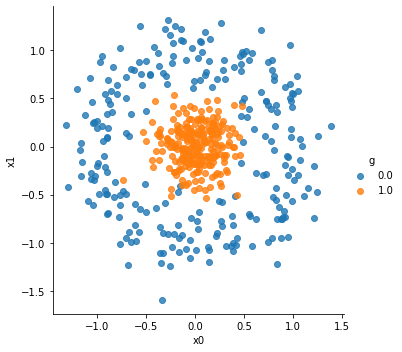

In [4]:
X = np.matrix(X)
g = np.matrix(g).T
logistic_reg_data = DataFrame( np.concatenate((X, g),axis=1), columns = ["x0", "x1", "g"])
sns.lmplot('x0','x1',logistic_reg_data,hue='g',fit_reg=False)

## Fitting a Logistic Regression

Given a categorical variable $y$ with 2 classes (binary variable), $y$ can best be described as a Bernoulli random variable - which is a random variable that takes the value $A$ with probability $p$ and the value $B$ with probability $1 - p$.  

We are interested in modeling the posterior probabilities of the 2 classes via some linear function in $x$.  

$y$ can best be described as a Bernoulli random variable, that is a variable that can assume two values

The model takes the form

$$ \log \frac{ \mathbb{P}(y = 1 | X = x) }{ \mathbb{P}(y = 0 | X = x) } = x\beta $$

The function on left hand side is known as the logit function.  

It can be shown then that 
$$ \mathbb{P}(y = 1 | X = x) = \frac{\exp(x\beta)}{(1 + \exp(x\beta)}$$
The function on the right is the __sigmoid function__ and is strictly between 0 and 1.  
and 
$$ \mathbb{P}(y = 0 | X = x) = 1 - \mathbb{P}(y = 1 | X = x)$$ 

Recall that the Bernoulli PDF takes the form 

$$p^{y}(1-p)^{1-y}$$

We will use objective function 

$$\frac{-1}{N}\sum_{i=1}^N \big(y_i\log(p_i) + (1 - y_i)\log(1 - p_i)\big)$$

This is the average surprisal and we will minimize our average surpise wrt $\beta$!  Unfortunately, there is not closed form solution to this problem and must be solved numerically.

## Last time 

In [5]:
## create the objective function 

class MSE(object):
    def valueAt( x, y, beta):
        yhat = x * b
        e = y - yhat
        return y.T*y / x.shape[0]
    def gradientAt(x, y, beta):
        yhat = x * beta
        e = y - yhat
        return -x.T*e / x.shape[0]
  
class L2(object):
    def valueAt(b):
        return 1/2*linalg.norm(b) 
    def gradientAt(b):
        return b
    
class GradientDescent(object):
    def __init__(self, cost_function=MSE, tolerance=1e-6, regularization=None):
        self.cost_function = cost_function
        self.tol = tolerance
        self.iter = 0
        self.beta = None
        self.regularization = regularization
        
    def optimize(self, X,y,learning_rate=0.1,init_params=None):
        if init_params is None:
            beta = np.matrix( np.zeros(X.shape[1])).T
        else:
            beta = init_params
        grad = self.cost_function.gradientAt(X,y,beta)
        if self.regularization is not None:
            pass
        prev_beta = beta
        beta = beta - learning_rate*grad
        ## several termination criteria to use
        ## abs change in beta is small
        ## abs change in beta / norm of beta 
        ## abs change in object is small
        ## here we use magitute of the gradient
        while np.linalg.norm(prev_beta - beta)/np.linalg.norm(beta) > self.tol:
            prev_beta = beta
            self.iter += 1
            grad = self.cost_function.gradientAt(X,y,beta)
            if self.regularization is not None:
                pass
            beta = beta - learning_rate*grad
        self.beta = beta
        return beta

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

## creating this as object to expose value and gradient methods 
class BCE(object):
    
    def valueAt( x, y, beta):
        p = sigmoid(x*beta)
        ll = y.T*(np.log(p + 1e-3)) + (1 - y).T*( np.log(1 - p + 1e-3))
        return -ll / x.shape[0]
        
    def gradientAt( x, y, beta):
        p = sigmoid(x*beta)
        grad = x.T.dot(y - p) / x.shape[0]
        return -grad

In [7]:
# let's add in the square of each X
X = np.concatenate( (X, np.multiply(X,X)) ,axis=1)

In [8]:
X = sma.add_constant(X)

In [9]:
logistic_regression = GradientDescent(BCE, tolerance=1e-7)
b = logistic_regression.optimize(X,g,learning_rate=10) ## show the perils of large learning rate
print("iterations: {}".format(logistic_regression.iter))
print(logistic_regression.beta.T)
BCE.valueAt(X,g,b)

iterations: 7081
[[  6.87189114  -1.5452632    0.43632932 -18.83842846 -19.94394414]]


matrix([[0.05699125]])

That's alot of iterations!  We can improve it by standardizing the features and playing with the learning rate

In [10]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
X = standardScaler.fit_transform(X[:,1:])
X = np.matrix(X)
X = sma.add_constant(X)

logistic_regression = GradientDescent(BCE, tolerance=1e-7)
b = logistic_regression.optimize(X,g,learning_rate=10) ## show the perils of large learning rate
print("iterations: {}".format(logistic_regression.iter))
print(logistic_regression.beta.T)
BCE.valueAt(X,g,b)

iterations: 1583
[[-4.24613477 -0.81655168  0.23639975 -7.32065413 -8.06246855]]


matrix([[0.05699114]])

## Model Performance

In [11]:
logistic_reg_data["phat"] = np.array(1*(sigmoid(X.dot(logistic_regression.beta))>0.5)).squeeze().tolist()
logistic_reg_data.head()

,x0,x1,g,phat
0,0.207810,0.258504,1.0,1
1,0.261353,-0.072018,1.0,1
2,0.464686,0.940512,0.0,0
3,-0.328772,0.766245,0.0,0
4,0.227187,-0.273839,1.0,1


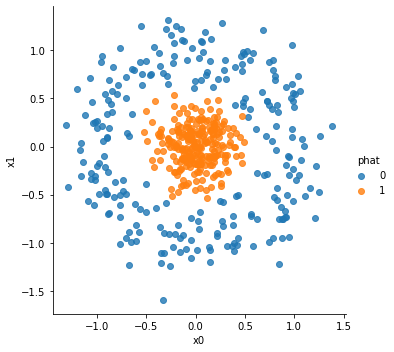

In [12]:
sns.lmplot('x0','x1',logistic_reg_data,hue='phat',fit_reg=False)

In [13]:
%%capture
!pip install pandasql 

In [14]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
## https://github.com/yhat/pandasql
pysqldf("select g, phat, sum(1) as n from logistic_reg_data group by g, phat;")

,g,phat,n
0,0.0,0,244
1,0.0,1,6
2,1.0,0,4
3,1.0,1,246


In [15]:
from sklearn.metrics import average_precision_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

See https://en.wikipedia.org/wiki/Precision_and_recall for more details

* Accuracy = (True Positive + True Negative) / N
* Recall = True Positive/(True Positive + False Negative)
* Precision = True Positive / (True Positive + False Positive)


In [16]:
recall = recall_score(logistic_reg_data.g, logistic_reg_data.phat)
precision = precision_score(logistic_reg_data.g, logistic_reg_data.phat)
accuracy = accuracy_score(logistic_reg_data.g, logistic_reg_data.phat)
print("recall: {0:.4f}".format(recall))
print("precision: {0:.4f}".format(precision))
print("accuracy: {0:.4f}".format(accuracy))

recall: 0.9840
precision: 0.9762
accuracy: 0.9800


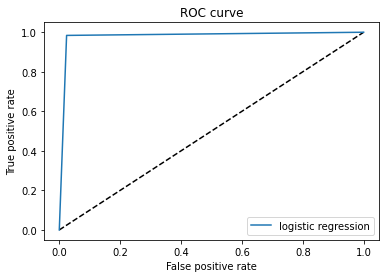

In [17]:
fpr, tpr, _  = roc_curve(logistic_reg_data.g, logistic_reg_data.phat)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='logistic regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Other APIs

## Statsmodels

In [18]:
import statsmodels.api as sma
import statsmodels as sm
fit = sma.GLM(endog = g, exog=X, family = sma.families.Binomial()).fit()
print(fit.summary())
sm_parms = fit.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      495
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29.169
Date:                Wed, 29 Jun 2022   Deviance:                       58.338
Time:                        13:16:53   Pearson chi2:                     180.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2462      0.843     -5.037      0.0

* Pseduo RSquare = 1 - model deviance / null model deviance

the null model is the intercept only model

In [19]:
pr2 = 1-fit.deviance / fit.null_deviance
print("pseudo r^2: {0:.4f}".format(pr2))

pseudo r^2: 0.9158


## Scikit learn

In [20]:
from sklearn.linear_model import LogisticRegression

In [40]:
sk_lr = LogisticRegression(fit_intercept=False, penalty = "none")

In [41]:
sk_lr_fit = sk_lr.fit(X, np.array(g.T)[0])

In [42]:
sklearn_parms = sk_lr_fit.coef_
print(sklearn_parms)

[[-4.24621079 -0.81656289  0.2364085  -7.3207608  -8.06258106]]


In [43]:
parms = DataFrame([np.array(b).ravel(), sklearn_parms.ravel(), sm_parms]).T
parms.columns = ["gd from scracth", "sklearn", "statsmodels"]
parms

,gd from scracth,sklearn,statsmodels
0,-4.246135,-4.246211,-4.246218
1,-0.816552,-0.816563,-0.816565
2,0.236400,0.236408,0.236412
3,-7.320654,-7.320761,-7.320775
4,-8.062469,-8.062581,-8.062591
